# Analyse predicted dmg on ISMIP files


In [1]:
import os
import rioxarray as rioxr
import xarray as xr
import cftime

import os
import rioxarray as rioxr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score
import numpy.polynomial.polynomial as poly

import rasterio as rio

import pandas as pd 
import cftime as cft

import seaborn as sns

# Import user functions
# get_tilelist_region, load_tile_yxt, clip_da_to_iceshelf, 
# load_tiles_region_multiyear, aggregate_region_ds_iceshelf , 
# remove_nanpx_multivar, fill_nan_cdata, reproject_match_grid
import myFunctions as myf 

homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'


In [2]:

# my_palette = sns.color_palette("blend:#7AB,#EDA")
my_palette = sns.color_palette('crest',5) # can access i'th color by indexing
display(my_palette)
# sns.color_palette('crest',5, as_cmap=True)


# cubeH_palette
cubeH_palette = sns.color_palette("cubehelix", 9)#[2:-1]
display(cubeH_palette)

# cubeH_palette
print('cubeH_palette for sectors')
cubeH_palette = sns.color_palette("cubehelix", 9)[2:-1]
display(sns.color_palette(cubeH_palette))

# plt.rcParams.update({'font.size': 16})
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from cycler import cycler
# class_palette = sns.color_palette("Set2",5 ).as_hex()
class_palette = sns.color_palette().as_hex()[:5]
class_palette[0]

model_cmap_list = []
for class_color in class_palette:
    class_clist = sns.color_palette("light:"+class_color,3) + sns.color_palette("dark:"+class_color+'_r',3)[1:] 
    model_cmap_list.append(class_clist)
    

my_palette = sns.color_palette('crest',5) # can access i'th color by indexing
my_palette

my_palette
my_palette2 = ['salmon']+ my_palette
# display(my_palette2)


### Timeseires 1997; 2015-2021
my_palette = sns.color_palette('crest',5) # can access i'th color by indexing
my_palette2 = ['salmon']+ my_palette
rgb_salmon = np.array([250,128,114])/255

my_palette2long = ['salmon']+ sns.color_palette('crest',7) 
rgb_salmon = tuple(np.array([250,128,114])/255)
my_palette2long = [rgb_salmon]+ sns.color_palette('crest',7) 
my_palette2rgb = [tuple(rgb_salmon)] + my_palette2long[1:] # only rgb values
print('Palette-long')
display(sns.color_palette(my_palette2rgb))

print('Palette-long: temporal_pallete 1997+crest : ', sns.color_palette(my_palette2long).as_hex()) 



[(0.46364792, 0.71617961, 0.56674986),
 (0.31270304, 0.62072111, 0.56379321),
 (0.20094292, 0.52087429, 0.55342884),
 (0.11409965, 0.42169502, 0.54065622),
 (0.13865499, 0.30988598, 0.50636017)]

[(0.10120483036935347, 0.08028952282539623, 0.18460915180334375),
 (0.08605633600581405, 0.23824692404212, 0.30561236308077167),
 (0.11789134778719829, 0.39694259707734425, 0.2588678372388254),
 (0.3292772926340829, 0.4762845556584382, 0.1837155549758328),
 (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 (0.8146245329198283, 0.49548316572322215, 0.5752525936416857),
 (0.812420762188067, 0.6167295569758052, 0.8578575836301946),
 (0.7587183008012618, 0.7922069335474338, 0.9543861221913403),
 (0.826811144552662, 0.9338331128274076, 0.9359622361392606)]

Palette-long


[(0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.50711872, 0.73665492, 0.56821764),
 (0.37890483, 0.66859548, 0.56566462),
 (0.28251558, 0.59517119, 0.56181204),
 (0.20094292, 0.52087429, 0.55342884),
 (0.12709242, 0.44601517, 0.54438795),
 (0.11646936, 0.36578429, 0.52726234),
 (0.15138673, 0.27982444, 0.49119848)]

Palette-long: temporal_pallete 1997+crest :  ['#fa8072', '#81bc91', '#61aa90', '#48988f', '#33858d', '#20728b', '#1e5d86', '#27477d']


#### TMP: update all "predicted_dmg" variables to something explicit, so that they can be loaded by xarray as group

In [3]:
## TMP: update variable name (so that not all are named 'predicted_dmg' )

def update_variable_names_in_files(file_list, old_var_name):
    for file_path in file_list:
        try:
            with xr.open_dataset(file_path) as ds:
                if old_var_name not in ds.variables:
                    print(f"Variable '{old_var_name}' not found in file: {file_path}")
                    continue

                # extract exp_num from filename
                exp_num = file_path.split('.')[0][-5:]
                if not exp_num.startswith('exp'):
                    exp_num = 'ctrl'
                new_var_name = 'D_'+exp_num

                # new filename 
                file_save = file_path.split('.')[0]+'_b.nc'

                ds = ds.rename({old_var_name: new_var_name})
                ds.to_netcdf(file_save, mode="w", engine="netcdf4")
                print(f"Variable name updated to {new_var_name} in file: {file_save}")
                ds.close()

        except Exception as e:
            print(f"Error occurred while processing file '{file_path}': {e}")


path2ismip = os.path.join(os.path.expanduser('~'),'Documents/Data/ISMIP6/')

model_options = ['AWI_PISM','DOE_MALI','ILTS_PIK_SICOPOLIS', 'JPL1_ISSM', 'NCAR_CISM']
ismip_model = 'JPL1_ISSM' 

for ismip_model in model_options:
    dmg_filelist = glob.glob( os.path.join(path2ismip,ismip_model,'damage/*.nc')  )
    dmg_filelist

    # Replace the following variables with your desired values
    old_variable_name = "predicted_dmg"

    # update_variable_names_in_files(dmg_filelist, old_variable_name)


## Load shapefiles for mask

In [4]:
''' --------------
Get Shapefiles 
------------------ '''
# geojson
gridTiles_geojson_path = os.path.join(homedir,'Data/tiles/gridTiles_iceShelves_EPSG3031.geojson')
gridTiles = gpd.read_file(gridTiles_geojson_path)

# measures ice shelves
iceshelf_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceShelf/IceShelf_Antarctica_v02.shp')
iceshelf_polygon_gpd = gpd.read_file(iceshelf_path_meas)

# measures grounding line
gl_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/GroundingLine_Antarctica_v2.shp')
groundingLine_gpd = gpd.read_file(gl_path_meas)

## regions of interest for AIS
roi_path = os.path.join(homedir, 'QGis/data_NeRD/plot_insets_AIS_regions.shp')
roi_poly = gpd.read_file(roi_path)

## redefined: SECTORS for AIS
roi_path = os.path.join(homedir, 'QGis/data_NeRD/plot_insets_AIS_sectors.shp')
roi_poly = gpd.read_file(roi_path)
region_ID_list = roi_poly['sector_ID'].to_list()

roi_poly

,sector_ID,sectorNAME,x_label,y_label,geometry
0,WS-2,None,NaN,NaN,"POLYGON ((-234790.440 1102885.003, -817199.621..."
1,WIS,West Indian,2500700.0,1980600.0,"POLYGON ((355417.402 2272581.101, 1130695.760 ..."
2,EIS,East Indian,2500700.0,-1700600.0,"POLYGON ((2742417.175 -38120.436, 2838893.457 ..."
3,RS,Ross Sea,-314500.0,-1700600.0,"POLYGON ((290784.599 -2038584.517, 222053.130 ..."
4,ASE,AmundsenSea,-2102000.0,-904500.0,"POLYGON ((-1904208.456 -569370.550, -1803318.2..."
5,BSE,Bellingshausen Sea,-2402000.0,402600.0,"POLYGON ((-1964742.593 -571892.806, -2021808.6..."
6,WS-1,None,NaN,NaN,"POLYGON ((-2492209.324 1662825.777, -1263071.7..."
7,WS,Weddell Sea,-1234600.0,1980600.0,"POLYGON ((-2492209.324 1662825.777, -398737.06..."
8,WIS-1,None,NaN,NaN,"POLYGON ((356705.110 2063501.039, 353255.687 2..."
9,WIS-2,None,NaN,NaN,"POLYGON ((1394097.053 1479840.930, 1733732.576..."


## Load data using open_mfdataset per ismip model

In [6]:

path2ismip = os.path.join(os.path.expanduser('~'),'Documents/Data/ISMIP6/')
path2ismip = os.path.join(homedir,'Data/ISMIP6/MODELS/')

model_options = ['AWI_PISM','DOE_MALI','ILTS_PIK_SICOPOLIS', 'JPL1_ISSM', 'NCAR_CISM']
# ismip_model = 'JPL1_ISSM' 

# exp_num='exp05'
# dmg_filelist = glob.glob( os.path.join(path2ismip,ismip_model,'damage/*_'+ exp_num +'.nc')  )



dmg_ds_list = [] 
for ismip_model in model_options:
    dmg_filelist = glob.glob( os.path.join(path2ismip,ismip_model,'damage/*.nc')  )

    ds = xr.open_mfdataset(dmg_filelist,  combine="by_coords",decode_times=False,
                  data_vars='minimal', coords='minimal', compat='broadcast_equals')
    dmg_ds_list.append(ds)

## CORRECT TIME LENGTHS

# fix DOE_MALI time shape (exp_ctrl had 100 elements rather than 86)
dmg_ds_list[1] = dmg_ds_list[1].isel(time=slice(0,86))
# fix NCAR_CISM time shape (has 87 elements rather than 86, one year longer)
dmg_ds_list[-1] = dmg_ds_list[-1].isel(time=slice(0,86))


In [7]:
## TIME INFO (but for now, assume the same annual 2015-2100 values for all model/experiments)
# for ismip_model in model_options:
#     # select exp06 , which had correct time for all models
#     file = glob.glob(  os.path.join(path2ismip,ismip_model,'orog*'+ismip_model+'*exp06.nc') )[0]
#     time_model = xr.open_dataset( file , decode_times=True ).time.values[0:86]

#     print('{:18s}  {}  {:20s}  {:20s}'.format(ismip_model, len(time_model), 
#                         str(time_model[0]), str(time_model[-1])) )

## assume same year values for all experiments
years = np.arange(2015,2101)
years

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])

In [8]:
## Fix SICOPOLIS lat/lon shittoe
for idx, var_ds in enumerate(dmg_ds_list):
    ismip_model = var_ds.attrs['model_abbrev']
    print(ismip_model)
    if 'CISM' in ismip_model or 'SICOPOLIS' in ismip_model:
        # drop latlon from dimensions
        try:
            var_ds = var_ds.drop(['lat','lon'])
        except:
            pass
        if 'SICOPOLIS' in ismip_model:
            var_ds = var_ds.drop(['crs'])
        ## set crs
        var_ds.rio.write_crs(3031,inplace=True)
        print(var_ds.coords)
    dmg_ds_list[idx] = var_ds


AWI_PISM
DOE_MALI
ILTS_PIK_SICOPOLIS
Coordinates:
  * y            (y) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * x            (x) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * time         (time) float64 9.36e+03 9.72e+03 ... 3.96e+04 3.996e+04
    spatial_ref  int64 0
JPL1_ISSM
NCAR_CISM
Coordinates:
  * y            (y) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * x            (x) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * time         (time) float64 7.3e+03 7.665e+03 ... 3.796e+04 3.832e+04
    spatial_ref  int64 0


In [9]:
dmg_ds_list[0]

<xarray.Dataset>
Dimensions:      (y: 761, x: 761, time: 86)
Coordinates:
    spatial_ref  int64 0
  * y            (y) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * x            (x) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * time         (time) float64 4.015e+03 4.38e+03 ... 3.468e+04 3.504e+04
Data variables:
    D_ctrl       (time, y, x) float64 dask.array<chunksize=(86, 761, 761), meta=np.ndarray>
    D_exp05      (time, y, x) float64 dask.array<chunksize=(86, 761, 761), meta=np.ndarray>
    D_exp06      (time, y, x) float64 dask.array<chunksize=(86, 761, 761), meta=np.ndarray>
    D_exp07      (time, y, x) float64 dask.array<chunksize=(86, 761, 761), meta=np.ndarray>
    D_exp08      (time, y, x) float64 dask.array<chunksize=(86, 761, 761), meta=np.ndarray>
Attributes:
    title:                Predicted damage on ISMIP6 Projections
    institution:          Alfred Wegener Institute for Polar and Marine Resea...
    source:               PISM
    model_abbrev:         AWI_PISM
    prediction_model:     RF_gridSearch_2023-07-10T12:47_res20x20
    prediction_features:  ['emax_1px', 'e_eff_1px', 'eshear_1px', 'elon_1px',...

## Clip data to ice shelves, aggregate values

In [10]:

# def sum_dmg_ds_year(dmg_ds, data_mask_gpd, normalise_px=True):
def sum_dmg_ds_year(dmg_ds, normalise_px=True):

    # ''' -------
    # Clip to Grounding line -- done before this function
    # ------------'''
    # dmg_ds_mask  = dmg_ds.rio.clip( data_mask_gpd.geometry, data_mask_gpd.crs, drop=False, invert=True)
    # # dmg_ds_mask.isel(time=3)[exp_var].plot.imshow()

    ''' -------
    - Aggregate to 1D 
    - Drop NaN
    ------------'''
    dmg_ds_stack = dmg_ds.stack(samples=['x','y']) # (time, samples)
    # valid_px_t = dmg_ds_1d.count(dim='samples')[exp_var].values 
    dmg_ds_stack  = dmg_ds_stack.dropna(dim='samples',how='all') # only drop samples where all time-steps have NaN value (i.e. the mask)
    valid_px_t = dmg_ds_stack.count(dim='samples') # [exp_var].values # array of valid pxs per timestep

    ''' -------
    Sum damage values per year 
    - normalise for #pixels, as some ISMIP models allow for changing ice front but others not
    ------------'''

    if normalise_px: 
        ## sum per year, divided by #px per year // this is equal to xarray.mean()
        # dmg_ds_sum_yr = dmg_ds_stack.sum(dim='samples' ) / valid_px_t # (time: 86)
        dmg_ds_sum_yr = dmg_ds_stack.mean(dim='samples' )# (time: 86) # time series of spatial mean
    else: 
        ## sum per year
        dmg_ds_sum_yr = dmg_ds_stack.sum(dim='samples' ) # (time: 86)

    return dmg_ds_sum_yr



In [42]:

''' -------
1D aggregation
------------'''


''' -------
Sum dmg values per year for all ISMIP models
------------'''
dmg_ds_1d_list1 = []
dmg_ds_1d_list2 = []
for idx , dmg_ds in enumerate(dmg_ds_list):
    print(idx)
    # if dmg_ds.attrs['model_abbrev'] == 'ILTS_PIK_SICOPOLIS':
    #     dmg_ds = dmg_ds.drop(['lat','lon','crs'])
    #     dmg_ds.rio.write_crs('EPSG:3031',inplace=True)    
    
    # Overwrite temporal value with the same time array for all ismip_models
    dmg_ds = dmg_ds.assign_coords(time=years) # annual values
    
    ''' -------
    Clip to Grounding line
    Mask data and calculate AIS sum
    ------------'''
    dmg_ds  = dmg_ds.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)

    dmg_ds_1d_model = sum_dmg_ds_year(dmg_ds, normalise_px=True) # ie. spatial average
    sumLabel = 'spatialAvg'
    dmg_ds_1d_list1.append(dmg_ds_1d_model)

    dmg_ds_1d_model2 = sum_dmg_ds_year(dmg_ds, normalise_px=False) # ie. spatial sum
    sumLabel2 = 'sum(dmg)'
    dmg_ds_1d_list2.append(dmg_ds_1d_model2)
    

dmg_ds_1d_all_avg = xr.concat(dmg_ds_1d_list1,dim='ismip_model') # (time, newDim)
dmg_ds_1d_all_avg.attrs['ismip_model_order'] = model_options


dmg_ds_1d_all_sum = xr.concat(dmg_ds_1d_list2,dim='ismip_model') # (time, newDim)
dmg_ds_1d_all_sum.attrs['ismip_model_order'] = model_options

dmg_ds_1d_all = dmg_ds_1d_all_sum ## Made most plots with this one!!

# dmg_ds_1d_all.load()
dmg_ds_1d_all_sum.load()

0
1
2
3
4


<xarray.Dataset>
Dimensions:      (time: 86, ismip_model: 5)
Coordinates:
  * time         (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
    spatial_ref  int64 0
Dimensions without coordinates: ismip_model
Data variables:
    D_ctrl       (ismip_model, time) float64 0.0 542.7 532.9 ... 367.2 367.2
    D_exp05      (ismip_model, time) float64 0.0 543.0 532.7 ... 359.1 358.8
    D_exp06      (ismip_model, time) float64 0.0 546.9 541.6 ... 357.2 360.9
    D_exp07      (ismip_model, time) float64 0.0 542.9 539.0 ... 355.1 355.8
    D_exp08      (ismip_model, time) float64 0.0 540.5 543.0 ... 346.3 345.5
Attributes:
    ismip_model_order:  ['AWI_PISM', 'DOE_MALI', 'ILTS_PIK_SICOPOLIS', 'JPL1_...

In [ ]:
raise RuntimeError

# Temporal Plot model ensemble; output wrt CTRL 
-- standardize model output by calculating the percentage changes of dmg, rather than absolute values

In [113]:
print('batlow map')
batlow10 = ["#011959","#103F60","#1C5A62","#3C6D56","#687B3E","#9D892B","#D29343","#F8A17B","#FDB7BC","#FACCFA"]
batlow6 = ["#1C5A62","#687B3E","#9D892B","#D29343","#F8A17B","#FDB7BC"]
display(sns.color_palette(batlow10))
display(sns.color_palette(batlow6))

batlow map


[(0.00392156862745098, 0.09803921568627451, 0.34901960784313724),
 (0.06274509803921569, 0.24705882352941178, 0.3764705882352941),
 (0.10980392156862745, 0.35294117647058826, 0.3843137254901961),
 (0.23529411764705882, 0.42745098039215684, 0.33725490196078434),
 (0.40784313725490196, 0.4823529411764706, 0.24313725490196078),
 (0.615686274509804, 0.5372549019607843, 0.16862745098039217),
 (0.8235294117647058, 0.5764705882352941, 0.2627450980392157),
 (0.9725490196078431, 0.6313725490196078, 0.4823529411764706),
 (0.9921568627450981, 0.7176470588235294, 0.7372549019607844),
 (0.9803921568627451, 0.8, 0.9803921568627451)]

[(0.10980392156862745, 0.35294117647058826, 0.3843137254901961),
 (0.40784313725490196, 0.4823529411764706, 0.24313725490196078),
 (0.615686274509804, 0.5372549019607843, 0.16862745098039217),
 (0.8235294117647058, 0.5764705882352941, 0.2627450980392157),
 (0.9725490196078431, 0.6313725490196078, 0.4823529411764706),
 (0.9921568627450981, 0.7176470588235294, 0.7372549019607844)]

,D_ctrl,D_exp05,D_exp06,D_exp07,D_exp08
mean(%),0.0,4.182761530998104,-0.077129288021621,-1.1241063803816655,-0.9805060412709595
min,0.0,-0.31081434047199796,-2.8226642465658944,-2.9798201148837915,-5.298005423473335
max,0.0,13.485402530926123,3.204921328807433,0.6793619248449976,3.609080672015674


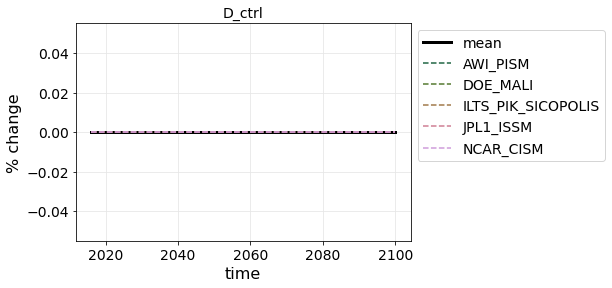

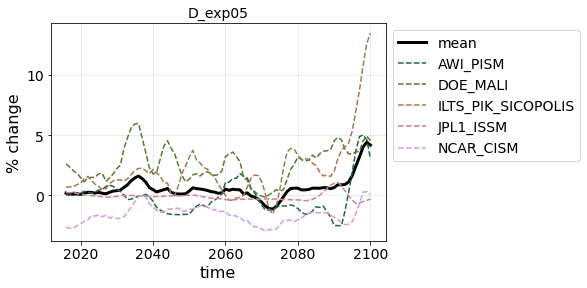

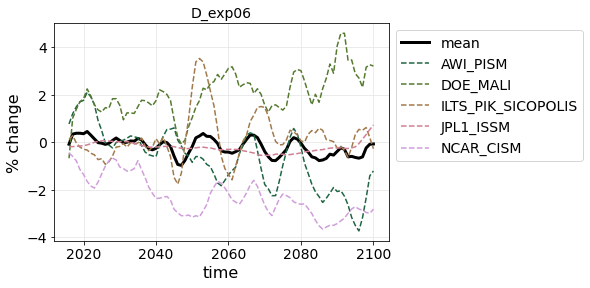

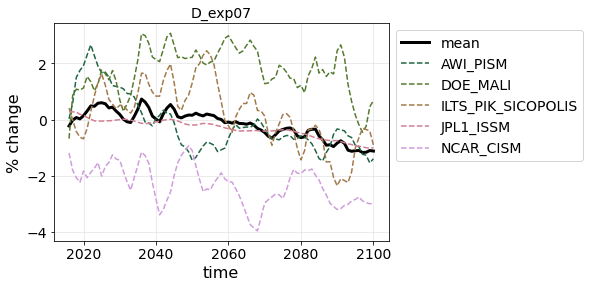

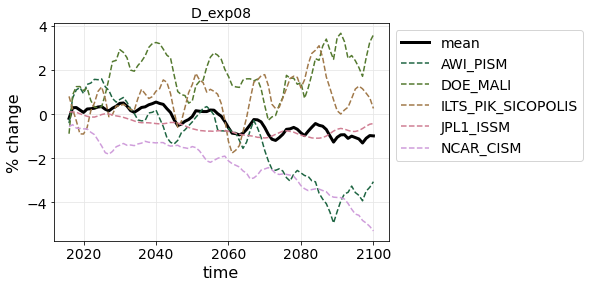

In [77]:
#HERE
exp_var='D_ctrl'

# d00 = dmg_ds_1d_all['D_ctrl'].isel(time=1) # first value per model (t=0 is nan)

var_list = list(dmg_ds_1d_all.data_vars)
# experiment_values_df = pd.DataFrame([]) # set up empty dataframe
exp_values = {};
for i, exp_var in enumerate( var_list ):
    color = my_palette[i]

    ## make time series relative (%) to t=0 (of itself)
    # exp_da = dmg_ds_1d_all[exp_var].isel(time=slice(1,86)) # drop t=0 as it has only nan # (model, time)
    # exp_da_pct = exp_da/d00 * 100  # dvide matrix (m x n)  by vector (m,1)

    ''' Spatial avg'''
    # ## make time series relative (%) wrt CTRL (of same model; difference per timestep)
    # exp_da   = dmg_ds_1d_all_avg[exp_var].isel(time=slice(1,86))   # drop t=0 as it has only nan
    # exp_ctrl = dmg_ds_1d_all_avg['D_ctrl'].isel(time=slice(1,86))# drop t=0 as it has only nan
    # exp_da_pct = (exp_da - exp_ctrl)  / exp_ctrl * 100

    ''' spatial sum '''
    ## make time series relative (%) wrt CTRL (of same model; difference per timestep)
    exp_da   = dmg_ds_1d_all_sum[exp_var].isel(time=slice(1,86))   # drop t=0 as it has only nan
    exp_ctrl = dmg_ds_1d_all_sum['D_ctrl'].isel(time=slice(1,86))# drop t=0 as it has only nan
    exp_da_pct = (exp_da - exp_ctrl)  / exp_ctrl * 100

    ## smooth output
    # exp_da_pct =  exp_da_pct.rolling(time=2, min_periods=1).mean()
    exp_da_pct =  exp_da_pct.rolling(time=5, min_periods=1).mean()
    # exp_da_pct =  exp_da_pct.rolling(time=10, min_periods=1).mean()

    ## calc mean and spread (std or minmax)
    exp_mean = exp_da_pct.mean(dim='ismip_model')

    # Print values at 2100
    exp_min = exp_da_pct.isel(time=-1).min(dim='ismip_model') # exp_mean - exp_std
    exp_max = exp_da_pct.isel(time=-1).max(dim='ismip_model') # exp_mean + exp_std

    ## add values to dictionary (this loads dask dataarray into memory, so pretty slow)
    exp_values[exp_var] = { 'mean(%)': exp_mean.isel(time=-1).values,
                            'min': exp_min.values,
                            'max': exp_max.values}

    fig,ax=plt.subplots(1,figsize=(6,4))
    # class_palette = sns.color_palette("Set2",5 )
    # ax.set_prop_cycle( cycler(color=my_palette) )
    ax.set_prop_cycle( cycler(color=cubeH_palette) )
    # ax.set_prop_cycle( cycler(color=batlow6) )

    # h = exp_mean.plot.line(ax=ax, x='time' , color='firebrick' )
    h = exp_mean.plot.line(ax=ax, x='time' , color='black',linewidth=3 )

    exp_da_pct.plot.line(ax=ax, x='time',linestyle='--' )#, color='gray' )
    
    # # Plot shaded areas for +/- 1 standard deviation from the mean
    # ax.fill_between(exp_mean['time'], exp_min, exp_max, 
    #                             color='gray', alpha=0.2)

    ax.set_title(exp_var)
    ax.set_ylabel('% change')
    ax.legend(['mean']+model_options, bbox_to_anchor=(1,1))
    ax.grid('major',color=[0.9, 0.9, 0.9],which='both')

    ### save fig
    figname = 'dmg_' + 'experimentEnsemble' + '_'+'percentageChange_wrtCTRL_'+ exp_var + '.png' # version1; also spatialSum
    figname = 'dmg_' + 'experimentEnsemble' + '_'+'percentageChange_wrtCTRL_'+ exp_var + '_Asum.png' # version2 spatial Sum (new colors)
    # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname), bbox_inches='tight')


exp_da_pct # .values
# d00.values

exp_values

experiment_values_df = pd.DataFrame(exp_values)
experiment_values_df

# Plot spatial: dmg change wrt ctrl; per RCP ensemble

In [ ]:

changeType = 'pctChange'
# changeType = 'absoluteChange'

In [ ]:
''' ------------------------
## Make ISMIP projections relative to CTRL of each own model
------------------------ '''
# dmg_ds_wrtCTRL_list = []
dmg_pctChange_2100_list =[]
dmg_absChange_2100_list =[]
for dmg_ds in dmg_ds_list:
    ## First temporal rolling mean
    dmg_ds = dmg_ds.rolling(time=5, min_periods=1).mean() # smooth ; (time, model)

    ## Then calcualte change wrt CTRL 
    dmg_ds_wrtCTRL = (dmg_ds-  dmg_ds['D_ctrl'] ) 
    dmg_ds_wrtCTRL_pct = (dmg_ds-  dmg_ds['D_ctrl'] ) / dmg_ds['D_ctrl'] * 100 
    # dmg_ds_wrtCTRL_list.append(dmg_ds_wrtCTRL)

    dmg_pctChange_2100_list.append(dmg_ds_wrtCTRL_pct.isel(time=-1).drop('time') )
    dmg_absChange_2100_list.append(dmg_ds_wrtCTRL.isel(time=-1).drop('time') )


''' ------------------------
### COMBINING SCENARIOS 
------------------------ '''
import dask
with dask.config.set(**{'array.slicing.split_large_chunks': True}):

    # concatenate all models per separate forcing sceenario
    # Only combine last time slice (as time array values are not generalised across models, concatenation would go amiss otherwise)

    if changeType == 'absoluteChange':
        dmg_change_2100_list = dmg_absChange_2100_list # absolute change
        attr_descript = 'Model Ensemble of dmg-absolute-change wrt ctrl at 2100'
    elif changeType == 'pctChange':
        dmg_change_2100_list = dmg_pctChange_2100_list # percentual change
        attr_descript = 'Model Ensemble of dmg-percent-change wrt ctrl at 2100'

    # RCP26_dmg_ds = xr.concat( [dmg_ds[['D_exp07']] for dmg_ds in dmg_change_2100_list], dim='model_dim' )
    # RCP85_dmg_ds = xr.concat( [dmg_ds[['D_exp05','D_exp06','D_exp08']] for dmg_ds in dmg_change_2100_list], dim='model_dim' )

    MODELS_dmg_ds = xr.concat( [dmg_ds[['D_exp05','D_exp06', 'D_exp07', 'D_exp08']] for dmg_ds in dmg_change_2100_list], dim='model_dim' )
    MODELS_dmg_ds.attrs['description'] = attr_descript
    

# MODELS_dmg_ds.load() # all experiments
MODELS_dmg_ds



<xarray.Dataset>
Dimensions:      (model_dim: 5, y: 761, x: 761)
Coordinates:
    spatial_ref  int64 0
  * y            (y) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * x            (x) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
Dimensions without coordinates: model_dim
Data variables:
    D_exp05      (model_dim, y, x) float64 dask.array<chunksize=(1, 761, 761), meta=np.ndarray>
    D_exp06      (model_dim, y, x) float64 dask.array<chunksize=(1, 761, 761), meta=np.ndarray>
    D_exp07      (model_dim, y, x) float64 dask.array<chunksize=(1, 761, 761), meta=np.ndarray>
    D_exp08      (model_dim, y, x) float64 dask.array<chunksize=(1, 761, 761), meta=np.ndarray>
Attributes:
    description:  Model Ensemble of dmg-percent-change wrt ctrl at 2100

In [ ]:
MODELS_dmg_ds.load() # all models, all experiments, at 2100

<xarray.Dataset>
Dimensions:      (model_dim: 5, y: 761, x: 761)
Coordinates:
    spatial_ref  int64 0
  * y            (y) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * x            (x) float64 -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
Dimensions without coordinates: model_dim
Data variables:
    D_exp05      (model_dim, y, x) float64 nan nan nan nan ... nan nan nan nan
    D_exp06      (model_dim, y, x) float64 nan nan nan nan ... nan nan nan nan
    D_exp07      (model_dim, y, x) float64 nan nan nan nan ... nan nan nan nan
    D_exp08      (model_dim, y, x) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Model Ensemble of dmg-percent-change wrt ctrl at 2100

#### check number of models per pixel

In [ ]:
data_mask = xr.where( np.isnan(MODELS_dmg_ds), 0, 1).sum(dim='model_dim')['D_exp05']# .plot.imshow()
# data_mask.plot.imshow(cmap='Set1')# .where(data_mask==1).plot.imshow()
# nanmask = np.isnan(MODELS_dmg_ds).sum(dim='model_dim')

## plot ensamble mean (deltaDMG @ 21000)

pctile bounds -27.859946309898557 -16.628961467327763


Text(0.5, 1.0, 'RCP85')

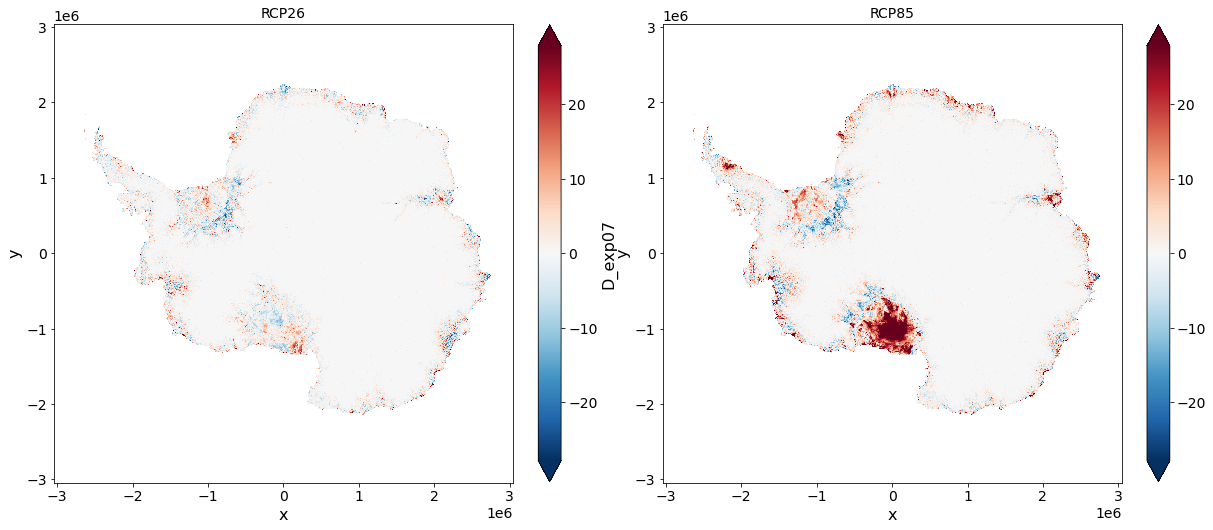

In [ ]:
## Calcualte Ensemble Mean 
RCP26_dmg2100_ensemble = MODELS_dmg_ds['D_exp07'].mean(dim='model_dim')

# mean of all models , all experiments
RCP85_dmg2100_ensemble = MODELS_dmg_ds[['D_exp05','D_exp06','D_exp08']].to_array('exp_dim').mean(dim=['model_dim','exp_dim'])

## Load to memory (for plotting faster) (MODELS_dmg_ds already loaded)
## RCP85_dmg2100_ensemble.load()
## RCP26_dmg2100_ensemble.load()


## determine visualisation bounds: min/max
# dd_min = MODELS_dmg_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
#      groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
#      ).min().values
# dd_max = MODELS_dmg_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
#      groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
#      ).max().values   
# print('minmax ', dd_min, dd_max)

## determine visualisation bounds: percentile
dd_min = np.nanpercentile( MODELS_dmg_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
     groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
     ) , 0.05) 
dd_max = np.nanpercentile(MODELS_dmg_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
     groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
     ), 0.95) 

vbounds = np.max([np.abs(dd_min), np.abs(dd_max)])
print('pctile bounds', dd_min, dd_max)

## minmax: -0.012 to 0.011
## pct 0.05 to 0.95: -0.007 to 0.004
## pct 0.01 to 0.99: -0.004 to 0.011

## plot
fig,axs=plt.subplots(1,2, figsize=(20,10))
ax=axs[0]
RCP26_dmg2100_ensemble.where(data_mask>=2 #).rio.clip(
    #  groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
     ).plot.imshow(ax=ax, vmin=-vbounds,vmax=vbounds, 
                        cmap='RdBu_r',  cbar_kwargs={'fraction':0.045} )
ax.set_aspect('equal')
ax.set_title('RCP26')

# fig,ax=plt.subplots(figsize=(10,10))
ax=axs[1]
RCP85_dmg2100_ensemble.where(data_mask>=2).plot.imshow(ax=ax, vmin=-vbounds,vmax=vbounds, 
                        cmap='RdBu_r',  cbar_kwargs={'fraction':0.045} )
ax.set_aspect('equal')
ax.set_title('RCP85')


## Save dmg change at 2100 to geotiff

In [ ]:
# RCP85_dmg2100_ensemble

In [ ]:

path2savetiff = os.path.join(homedir,'Data/ISMIP6/figures/maps/')

# ## RCP85
# fname = 'dmg_'+changeType+'-2100_modelEnsemble_RCP85.tif'
# RCP85_dmg2100_ensemble.name = 'dmg_'+changeType
# Save geotiff; mask pixels where only 1 model has output (edges of ice shelves), ie. only keep pixels with 2 or more datavalues.
# RCP85_dmg2100_ensemble.where(data_mask>=2).to_dataset(name='dmg_'+changeType).rio.to_raster( 
#                 os.path.join(path2savetiff, fname) ,driver="COG")

# Save geotiff; mask pixels where only 1 model has output (edges of ice shelves), ie. only keep pixels with 2 or more datavalues.
# also clip grounding line
fname = 'dmg_'+changeType+'-2100_modelEnsemble_RCP85_clipped.tif'
RCP85_dmg2100_ensemble.name = 'dmg_'+changeType
if not os.path.isfile(os.path.join(path2savetiff, fname)):
    RCP85_dmg2100_ensemble.where(data_mask>=2).to_dataset(name='dmg_'+changeType).rio.clip(
        groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
        ).rio.to_raster( os.path.join(path2savetiff, fname) ,driver="COG")
else:
    print('file exsits -- skipped')

file exsits -- skipped


In [ ]:

## RCP26
# fname = 'dmg_p'+changeType+'-2100_modelEnsemble_RCP26.tif'
# RCP26_dmg2100_ensemble.name = 'dmg_'+changeType
# # Save geotiff
# # RCP26_dmg2100_ensemble.where(data_mask>=2).to_dataset(name='dmg_'+changeType).rio.to_raster( 
# #                 os.path.join(path2savetiff, fname) ,driver="COG")


# # also clip grounding line
fname = 'dmg_'+changeType+'-2100_modelEnsemble_RCP26_clipped.tif'
RCP26_dmg2100_ensemble.name = 'dmg_'+changeType

if not os.path.isfile(os.path.join(path2savetiff, fname)):
    RCP26_dmg2100_ensemble.where(data_mask>=2).to_dataset(name='dmg_'+changeType).rio.clip(
        groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
        ).rio.to_raster( os.path.join(path2savetiff, fname) ,driver="COG")
else:
    print('file exsits -- skipped')

## Plot ensemble@2100 per experiment

In [ ]:
changeType

'pctChange'

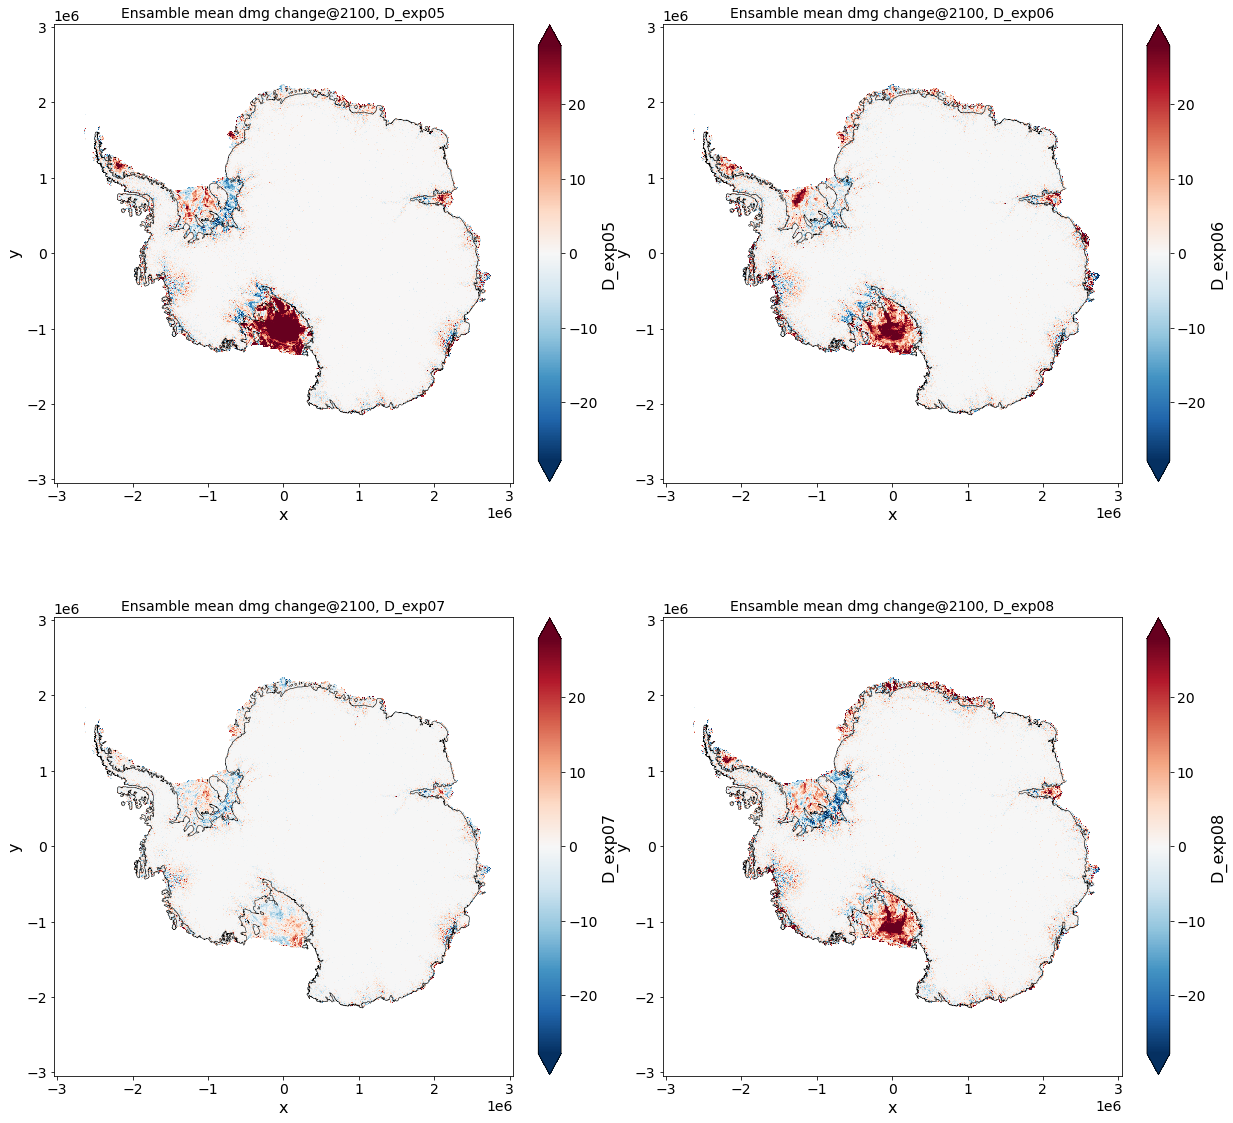

In [ ]:

fig,axs=plt.subplots(2,2, figsize=(20,20)) 
r=0;c=0
for exp_var in ['D_exp05','D_exp06','D_exp07','D_exp08']:

    ax=axs[r,c]
    ## ensemble mean
    MODELS_dmg_ds[exp_var].mean(dim='model_dim').where(data_mask>=2).plot.imshow(ax=ax, vmin=-vbounds,vmax=vbounds, 
                            cmap='RdBu_r',  cbar_kwargs={'fraction':0.045}
                            )
    ax.set_title('Ensamble mean dmg change@2100, ' + exp_var)
    figname = 'dmg2100_ensembleMean' + '_'+changeType+'_wrtCTRL_'+ 'experiments' + '.png'

    ## ensemble median
    # MODELS_dmg_ds[exp_var].median(dim='model_dim').where(data_mask>=2).plot.imshow(ax=ax, vmin=-vbounds,vmax=vbounds, 
    #                         cmap='RdBu_r',  cbar_kwargs={'fraction':0.045}
    #                         )
    # ax.set_title('Ensamble median dmg change@2100, ' + exp_var)
    # figname = 'dmg2100_ensembleMedian' + '_'+changeType+'_wrtCTRL_'+ 'experiments' + '.png'

    ## Plot grounding line
    # iceshelf_polygon_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
    groundingLine_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
                            
    ax.set_aspect('equal')
    c+=1
    if c>1:
        c=0
        r+=1

# ## save fig
## figname = 'dmg2100_ensembleMean' + '_'+changeType+'_wrtCTRL_'+ exp_var + '.png'
## figname = 'dmg2100_ensembleMean' + '_'+changeType+'_wrtCTRL_'+ 'experiments' + '.png'

# fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/maps/',figname), bbox_inches='tight')




## Plot per model  per experiment at 2100 -- also save to tiff

.. saving  dmg_pctChange-2100_AWI_PISM_D_exp05.tif
.. saving  dmg_pctChange-2100_AWI_PISM_D_exp06.tif
.. saving  dmg_pctChange-2100_AWI_PISM_D_exp07.tif
.. saving  dmg_pctChange-2100_AWI_PISM_D_exp08.tif
.. saving  dmg_pctChange-2100_DOE_MALI_D_exp05.tif
.. saving  dmg_pctChange-2100_DOE_MALI_D_exp06.tif
.. saving  dmg_pctChange-2100_DOE_MALI_D_exp07.tif
.. saving  dmg_pctChange-2100_DOE_MALI_D_exp08.tif
.. saving  dmg_pctChange-2100_ILTS_PIK_SICOPOLIS_D_exp05.tif
.. saving  dmg_pctChange-2100_ILTS_PIK_SICOPOLIS_D_exp06.tif
.. saving  dmg_pctChange-2100_ILTS_PIK_SICOPOLIS_D_exp07.tif
.. saving  dmg_pctChange-2100_ILTS_PIK_SICOPOLIS_D_exp08.tif
.. saving  dmg_pctChange-2100_JPL1_ISSM_D_exp05.tif
.. saving  dmg_pctChange-2100_JPL1_ISSM_D_exp06.tif
.. saving  dmg_pctChange-2100_JPL1_ISSM_D_exp07.tif
.. saving  dmg_pctChange-2100_JPL1_ISSM_D_exp08.tif
.. saving  dmg_pctChange-2100_NCAR_CISM_D_exp05.tif
.. saving  dmg_pctChange-2100_NCAR_CISM_D_exp06.tif
.. saving  dmg_pctChange-2100_NCAR_C

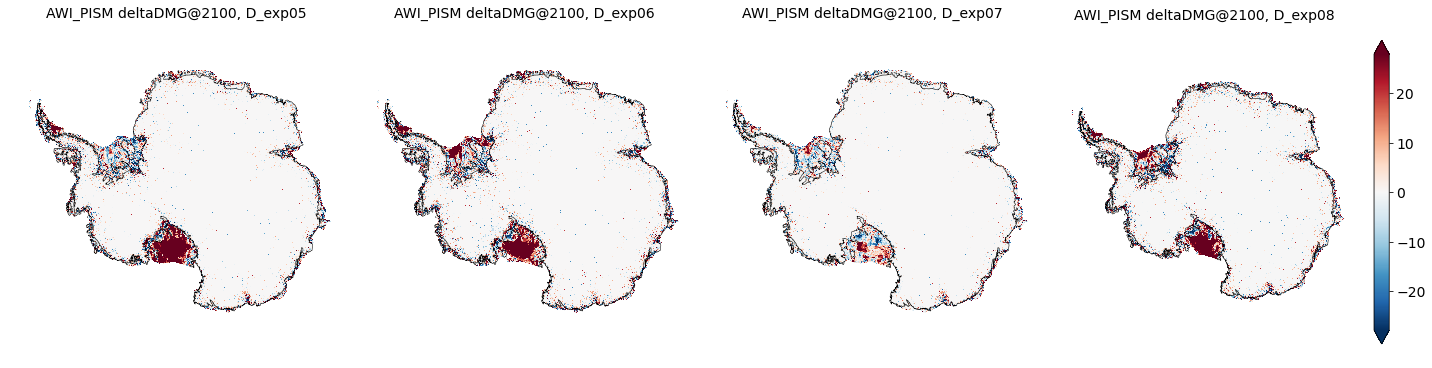

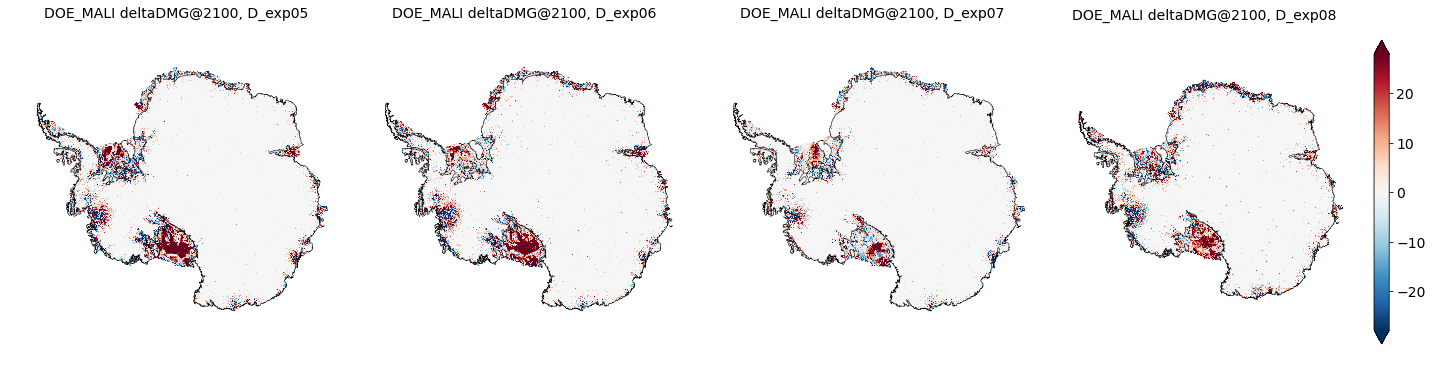

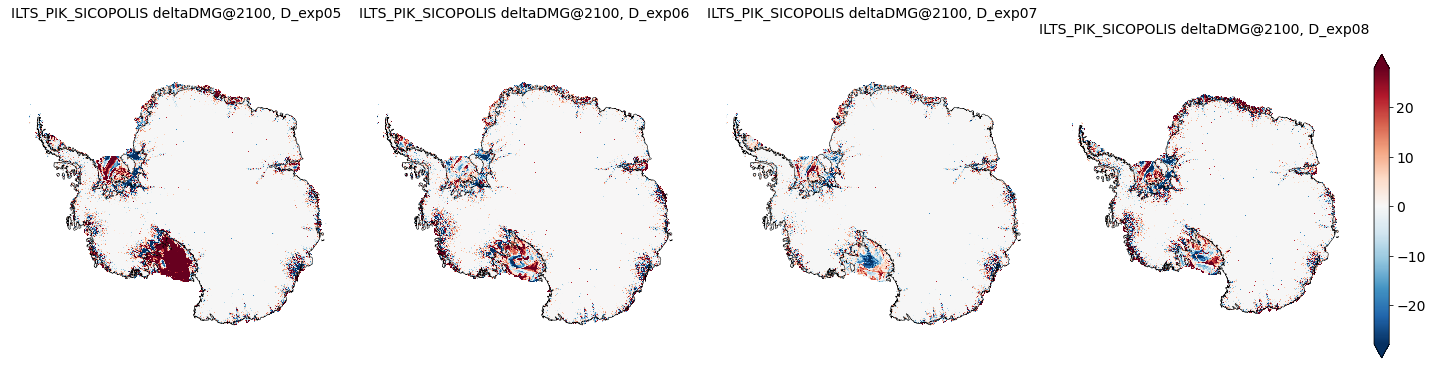

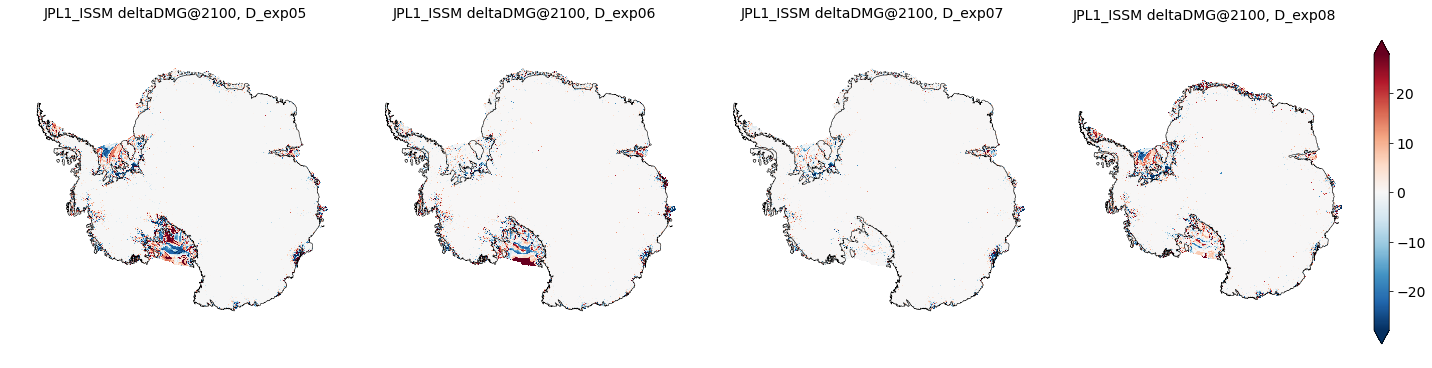

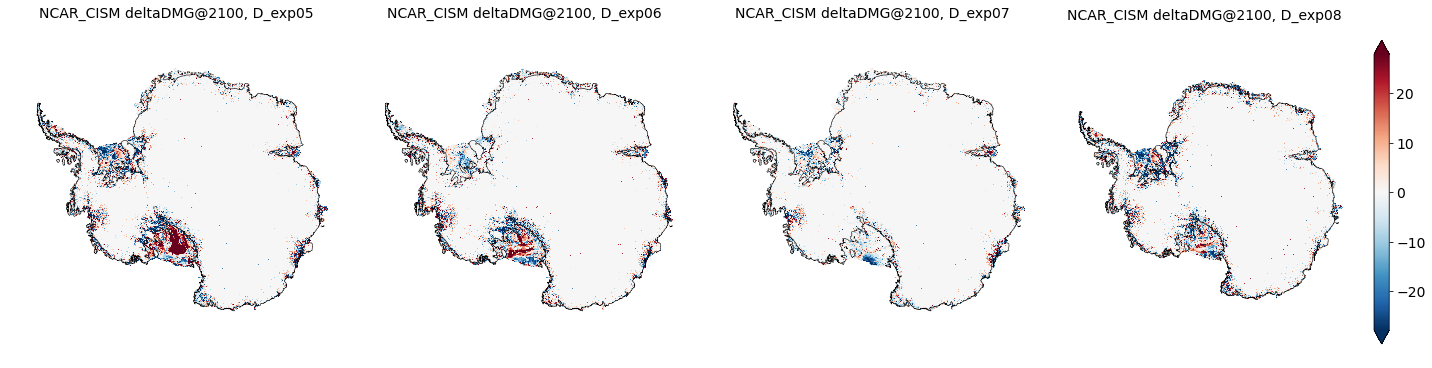

In [ ]:
MODELS_dmg_ds

for model_idx in range(MODELS_dmg_ds.model_dim.size) :
    # ax=axs[r,c]
    fig,axs=plt.subplots(1,4, figsize=(20,8)) 
    model_data = MODELS_dmg_ds.isel(model_dim=model_idx)
    # model_data.name = 'dmg_'+changeType
    for k, exp_var in enumerate(['D_exp05','D_exp06','D_exp07','D_exp08']):
        ax=axs[k]
        # if k<3:
        c= MODELS_dmg_ds.isel(model_dim=model_idx)[exp_var].plot.imshow(ax=ax, vmin=-vbounds,vmax=vbounds, 
                            cmap='RdBu_r',  add_colorbar=False, # cbar_kwargs={'fraction':0.045}, 
                            )
        if k==3:
            cbar = plt.colorbar(c,ax=ax,extend='both',label='',fraction=0.045) # plt.colorbar().ax.set_ylabel('Label')
        ax.set_aspect('equal'); ax.set_axis_off()
        # iceshelf_polygon_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
        groundingLine_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
        ax.set_title(model_options[model_idx] + ' deltaDMG@2100, ' + exp_var)


        '''## save tif'''
        # # also clip grounding line
        fname = 'dmg_'+changeType+'-2100_'+ model_options[model_idx]+  '_' + exp_var + '.tif'
        
        if not os.path.isfile(os.path.join(path2savetiff, fname)):
            print('.. saving ',fname)
            model_data[exp_var].to_dataset(name='dmg_'+changeType).rio.clip(
                groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
                ).rio.to_raster( os.path.join(path2savetiff, fname) ,driver="COG")
        else:
            print('file exsits -- skipped')

    fig.tight_layout()

    ## save fig
    # figname = 'dmg2100_' +changeType+'_wrtCTRL_' + model_options[model_idx]+  '_' + 'experiments' + '.png'
    # print('.. saving to ', figname)
    # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/maps/',figname), bbox_inches='tight')



# Calculate regional values

In [ ]:
region_ID_list = [ID for ID in region_ID_list if '-' not in ID]
region_ID_list.sort()
region_ID_list

region_labels = [roi_poly.loc[roi_poly['sector_ID'] == ID]['sectorNAME'].iloc[0] for ID in region_ID_list]

region_ID_list

['ASE', 'BSE', 'EIS', 'RS', 'WIS', 'WS']

In [ ]:
## Calculate regional values 
ensemble_t2100_list=[]
ensemble_t2100_list_abs=[]
for region_ID in region_ID_list:
    print('-- REGION: ', region_ID)

    ## Select region
    region_gpd = roi_poly.loc[roi_poly['sector_ID'] == region_ID]
    region_name = region_gpd['sectorNAME'].values[0] 

    '''## Get ensemble'''
    
    # fig,axs=plt.subplots(5,1,figsize=(6,20))
    # fig,axs=plt.subplots(3,1,figsize=(6,12))
    k=0
    model_ds_1d_list = []
    for model_idx , var_ds in enumerate(dmg_ds_list):
        ismip_model = var_ds.attrs['model_abbrev']
        # print(ismip_model)

        ## Overwrite temporal value with the same time array for all ismip_models'''
        var_ds = var_ds.assign_coords(time=years) # annual values
        
        ## Clip to mask (e.g. Grounding line)
        var_ds  = var_ds.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)
        
        ## CLIP TO SELECTED REGION
        var_ds  = var_ds.rio.clip( region_gpd.geometry, region_gpd.crs, drop=False, invert=False)

        ## Aggergate: Stack samples to 1D 
        # var_ds_stack = var_ds.isel(time=yidx).stack(samples=['x','y']) # select one year
        var_ds_stack = var_ds.stack(samples=['x','y']) 

        # Calculate Spatial average
        var_exp_1d = var_ds_stack.mean(dim='samples') # time series of spatial mean

        # stack to list
        model_ds_1d_list.append(var_exp_1d)
    
    # single DA for all models; current region
    model_region_ensemble = xr.concat(model_ds_1d_list,dim='ismip_model') # (time, newDim)


    ''' Get ensemble of percent-change '''

    exp_ctrl = model_region_ensemble['D_ctrl'] #.isel(time=slice(1,86))# drop t=0 as it has only nan; dataArray (model, time)
    model_region_ensemble_pct = ( model_region_ensemble.drop(['D_ctrl']) - exp_ctrl )  / exp_ctrl * 100 # dataset minus dataArray
    model_region_ensemble_pct = model_region_ensemble_pct.rolling(time=5, min_periods=1).mean() # smooth ; (time, model)
    # COnvert dataset with multivar to dataset with single var (experiment, model) 
    # where each model has 1 single value per experiment (i.e the %-change at 2100)
    region_ensemble_t2100 = model_region_ensemble_pct.isel(time=-1).to_array('experiment').to_dataset(name=region_ID)

    ensemble_t2100_list.append( region_ensemble_t2100 ) # list of dataArrays

    ''' Get ensemble of absolute-change '''

    exp_ctrl = model_region_ensemble['D_ctrl'] #.isel(time=slice(1,86))# drop t=0 as it has only nan; dataArray (model, time)
    model_region_ensemble_abs = ( model_region_ensemble.drop(['D_ctrl']) - exp_ctrl )  # dataset minus dataArray
    model_region_ensemble_abs = model_region_ensemble_abs.rolling(time=5, min_periods=1).mean() # smooth ; (time, model)
    # COnvert dataset with multivar to dataset with single var (experiment, model) 
    # where each model has 1 single value per experiment (i.e the %-change at 2100)
    region_ensemble_t2100_abs = model_region_ensemble_abs.isel(time=-1).to_array('experiment').to_dataset(name=region_ID)

    ensemble_t2100_list_abs.append( region_ensemble_t2100_abs ) # list of dataArrays


### load percent-change into memory
if changeType == 'percentChange':
    regional_pct_ds = xr.merge( ensemble_t2100_list) # dataste
    # regional_pct_ds.load() 

    # Convert to DF
    regional_pct_df = regional_pct_ds.to_dataframe().drop(['time','spatial_ref'],axis=1).reset_index() # 

elif changeType == 'absoluteChange':
    regional_abs_ds = xr.merge( ensemble_t2100_list_abs)

    ### absolute changes as well
    # regional_abs_ds.load() 

    # Convert to DF
    regional_abs_df = regional_abs_ds.to_dataframe().drop(['time','spatial_ref'],axis=1).reset_index() # 
    

-- REGION:  ASE
-- REGION:  BSE
-- REGION:  EIS
-- REGION:  RS
-- REGION:  WIS
-- REGION:  WS


In [1]:

regional_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment']!='D_exp07'].drop('ismip_model',axis=1)
regional_df_RCP26 = regional_pct_df.loc[regional_pct_df['experiment']=='D_exp07'].drop('ismip_model',axis=1)
label='% change'



In [ ]:
MODELS_dmg_ds # (model_dim, y, x); time slice at 2100
RCP26_dmg2100_ensemble # (y,x)

''' Data prep '''

## Calcualte Ensemble Mean 
RCP26_dmg2100_ensemble = MODELS_dmg_ds['D_exp07'].mean(dim='model_dim')
RCP85_dmg2100_ensemble = MODELS_dmg_ds[['D_exp05','D_exp06','D_exp08']].to_array('exp_dim').mean(dim=['model_dim','exp_dim'])


'''## Calculate regional values '''
region_t2100_scenarios = []
for var_ds_in in [RCP26_dmg2100_ensemble, RCP85_dmg2100_ensemble]:
    ## for scenario ensemble, aggergate regional values to 1D
    print(' --- Scenario i')

    ## Clip to mask (e.g. Grounding line)
    var_ds_gl  = var_ds_in.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)



    ensemble_t2100_list=[]
    for region_ID in region_ID_list:
        print('-- REGION: ', region_ID)

        ## Select region
        region_gpd = roi_poly.loc[roi_poly['sector_ID'] == region_ID]
        region_name = region_gpd['sectorNAME'].values[0] 
            
        ## CLIP TO SELECTED REGION
        var_ds  = var_ds_gl.rio.clip( region_gpd.geometry, region_gpd.crs, drop=True, invert=False)

        ## Aggergate: Stack samples to 1D 
        # var_ds_stack = var_ds.isel(time=yidx).stack(samples=['x','y']) # select one year
        var_ds_stack = var_ds.stack(samples=['x','y']) 

        # Calculate Spatial average
        # var_exp_1d = var_ds_stack.mean(dim='samples') # yields 1 value per region (at t=2100)

        # Drop NaN pxs
        var_ds_stack = var_ds_stack.dropna(dim='samples')
        var_ds_stack.attrs['sector_ID'] = region_ID

        # stack to list with each region
        ensemble_t2100_list.append( var_ds_stack ) # list with 1D dataArrays
    #     model_ds_1d_list.append(var_exp_1d)

    region_t2100_scenarios.append(ensemble_t2100_list)

RCP26_dmg2100_ensemble_stacklist_regions, RCP85_dmg2100_ensemble_stacklist_regions = tuple(region_t2100_scenarios)


# ### load percent-change into memory
# regional_pct_ds = xr.merge( ensemble_t2100_list) # dataste
# # regional_pct_ds.load() 
# regional_pct_ds

# Convert to DF
# regional_pct_df = regional_pct_ds.to_dataframe().drop(['time','spatial_ref'],axis=1).reset_index() # 

# regional_pct_df
# var_ds_stack
# RCP26_dmg2100_ensemble_stacklist_regions

 --- Scenario i
-- REGION:  ASE
-- REGION:  BSE
-- REGION:  EIS
-- REGION:  RS
-- REGION:  WIS
-- REGION:  WS
 --- Scenario i
-- REGION:  ASE
-- REGION:  BSE
-- REGION:  EIS
-- REGION:  RS
-- REGION:  WIS
-- REGION:  WS


In [ ]:
# regional_pct_df

# # RCP26_dmg2100_ensemble_stacklist_regions

# ## Single value per region
# # for region_ID in 
# RCP26_dmg2100_ensemble_stacklist_regions[0].mean(dim='samples').values
# # regional_pct_df

,experiment,ismip_model,ASE,BSE,EIS,RS,WIS,WS
0,D_exp05,0,0.726859,1.595982,5.440832,36.344388,1.808485,-0.247044
1,D_exp05,1,0.246756,0.184916,-0.116217,14.454136,2.871392,0.985066
2,D_exp05,2,8.058499,2.339739,7.192658,46.440582,9.371773,-1.688345
3,D_exp05,3,-1.456922,1.899274,0.061988,2.067232,-0.436315,-2.209607
4,D_exp05,4,-2.572791,-0.866207,-2.325541,13.128037,-2.821662,-6.388995
5,D_exp06,0,4.257661,0.738650,4.407495,23.419830,2.704309,4.901781
6,D_exp06,1,1.295917,-0.614439,9.101536,16.048692,3.131415,2.922085
7,D_exp06,2,12.420590,4.977910,8.318546,5.134634,8.484658,-1.928369
8,D_exp06,3,0.547947,-0.595636,0.135132,3.693939,1.886650,-1.408192
9,D_exp06,4,-0.616139,0.190538,-0.362256,0.234645,-4.125222,-2.602084


In [ ]:
# regional_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment']!='D_exp07'].drop('ismip_model',axis=1)
# regional_df_RCP26 = regional_pct_df.loc[regional_pct_df['experiment']=='D_exp07'].drop('ismip_model',axis=1)
# xvar = 'DeltaDMG(%)'
regional_df_RCP85 = regional_abs_df.loc[regional_abs_df['experiment']!='D_exp07'].drop('ismip_model',axis=1)
regional_df_RCP26 = regional_abs_df.loc[regional_abs_df['experiment']=='D_exp07'].drop('ismip_model',axis=1)
xvar = 'DeltaDMG'

df_long_RCP26 = regional_df_RCP26.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=xvar)
df_long_RCP85 = regional_df_RCP85.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=xvar)
df_long_RCP26['scenario']='RCP2.6'
df_long_RCP85['scenario']='RCP8.5'
df_long_both = pd.concat([df_long_RCP26, df_long_RCP85])
df_long_both


### 
fig,axs=plt.subplots(1,figsize=(7,7))
ax=axs
bp = sns.barplot(data=df_long_both, y='sector',x=xvar,
                    ax=ax, hue='scenario',
                    palette=[my_palette2[-2],my_palette2[0]],
                    # palette=cubeH_palette[2:-1],#'Set2',
                    capsize=.1,errcolor='0.26',errwidth=0.9)
# ymin, ymax = ax.get_ylim() # -0.8; 5.8
# ax.set_title('DMG change at 2100 wrt ctrl')
ax.set_yticklabels(region_labels)#,rotation=90);#,ha='right');
ax.set_xlabel( xvar + ' wrt ctrl at 2100'); ax.set_ylabel('')
ax.legend(fontsize=14)
fig.tight_layout()
ax.xaxis.grid(True, color=[0.9 , 0.9, 0.9])
# ax.vlines(0,*ax.get_ylim(),colors='black',linestyles='--', linewidth=0.9)



# ### save fig
# # figname = 'dmg_barplot_percentChange2100_sectors_scenario_horiz.png'
# figname = 'dmg_barplot_'+changeType+'2100_sectors_scenario_horiz.png'
# print(figname)
# fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname), bbox_inches='tight')

NameError: name 'regional_abs_df' is not defined

### Bar plot with swarmplot


saving.. dmg_barplot-stripplot_pctChange2100_sectors_scenario_horiz


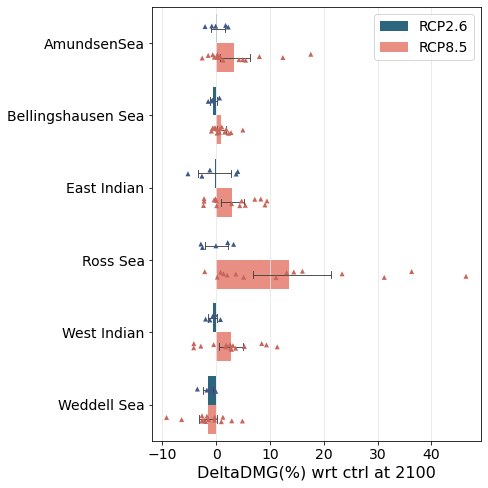

In [ ]:
regional_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment']!='D_exp07']#.drop('ismip_model',axis=1)
regional_df_RCP26 = regional_pct_df.loc[regional_pct_df['experiment']=='D_exp07']#.drop('ismip_model',axis=1)
xvar = 'DeltaDMG(%)'
# regional_df_RCP85 = regional_abs_df.loc[regional_abs_df['experiment']!='D_exp07'].drop('ismip_model',axis=1)
# regional_df_RCP26 = regional_abs_df.loc[regional_abs_df['experiment']=='D_exp07'].drop('ismip_model',axis=1)
# xvar = 'DeltaDMG'

# ## convert to long-format using 'experiment' 
# df_long_RCP26 = regional_df_RCP26.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=xvar)
# df_long_RCP85 = regional_df_RCP85.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=xvar)
# df_long_RCP26['scenario']='RCP2.6'
# df_long_RCP85['scenario']='RCP8.5'
# df_long_both = pd.concat([df_long_RCP26, df_long_RCP85])
# df_long_both

## convert to long-format using both 'experiment' and 'ismip model' 
df_long_RCP26 = regional_df_RCP26.melt(id_vars=['experiment','ismip_model'],value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=xvar)
df_long_RCP85 = regional_df_RCP85.melt(id_vars=['experiment','ismip_model'],value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=xvar)
df_long_RCP26['scenario']='RCP2.6'
df_long_RCP85['scenario']='RCP8.5'
df_long_both = pd.concat([df_long_RCP26, df_long_RCP85])
df_long_both


'''###  BAR AND SWARM'''
# # fig,axs=plt.subplots(1,figsize=(7,7))
# fig,axs=plt.subplots(1,2,figsize=(15,7))
# ax=axs[0]
# bp = sns.barplot(data=df_long_both, y='sector',x=xvar,
#                     ax=ax, hue='scenario',
#                     palette=[my_palette2[-2],my_palette2[0]],
#                     capsize=.1,errcolor='0.26',errwidth=0.9)
# sp = sns.swarmplot(data=df_long_both, y='sector',x=xvar,
#                     ax=ax, hue='scenario',#style='ismip_model',
#                     palette=[my_palette2[-2],my_palette2[0]],
#                     )
# ax.set_yticklabels(region_labels)#,rotation=90);#,ha='right');
# ax.set_xlabel( xvar + ' wrt ctrl at 2100'); ax.set_ylabel('')
# ax.legend(fontsize=14)
# ax.xaxis.grid(True, color=[0.9 , 0.9, 0.9])
# # ax.vlines(0,*ax.get_ylim(),colors='black',linestyles='--', linewidth=0.9)

'''## BAR AND STRIPPLOT'''
fig,axs=plt.subplots(1,figsize=(7,7))
ax=axs#[1]
bp = sns.barplot(data=df_long_both, y='sector',x=xvar,
                    ax=ax, hue='scenario',
                    palette=[my_palette2[-2],my_palette2[0]],
                    capsize=.1,errcolor='0.26',errwidth=0.9)
sp = sns.stripplot(data=df_long_both, y='sector',x=xvar,
                    ax=ax, hue='scenario', 
                    jitter=True,dodge=True, marker='^', 
                    # palette=[my_palette2[-2],my_palette2[0]],
                    # edgecolor='black', linewidth=0.3, size=8,
                    palette=['#3c598a','#c8665b'], # 2 shades darker from salmon; 1 shades lighter from darkblue
                    edgecolor=None, legend=False,
                    )

ax.set_yticklabels(region_labels)#,rotation=90);#,ha='right');
ax.set_xlabel( xvar + ' wrt ctrl at 2100'); ax.set_ylabel('')
ax.legend(fontsize=14)
ax.xaxis.grid(True, color=[0.9 , 0.9, 0.9])


fig.tight_layout()

# ### save fig
figname = 'dmg_barplot-stripplot_'+changeType+'2100_sectors_scenario_horiz' # 
print('saving..', figname)
# # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname), bbox_inches='tight')
# # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname+'.png'), bbox_inches='tight')
# # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname+'.svg'), bbox_inches='tight')
# fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname+'.pdf'), bbox_inches='tight')

In [ ]:
df_long_both.loc[df_long_both['sector']=='ASE']
scatter_values_region = df_long_both.loc[df_long_both['sector']==label.get_text()]
x_rcp26 = scatter_values_region.loc[scatter_values_region['scenario'] == 'RCP2.6']
x_rcp85 = scatter_values_region.loc[scatter_values_region['scenario'] == 'RCP8.5']
x_rcp26
x_rcp85

,experiment,ismip_model,sector,DeltaDMG(%),scenario
75,D_exp05,0,WS,-0.247044,RCP8.5
76,D_exp05,1,WS,0.985066,RCP8.5
77,D_exp05,2,WS,-1.688345,RCP8.5
78,D_exp05,3,WS,-2.209607,RCP8.5
79,D_exp05,4,WS,-6.388995,RCP8.5
80,D_exp06,0,WS,4.901781,RCP8.5
81,D_exp06,1,WS,2.922085,RCP8.5
82,D_exp06,2,WS,-1.928369,RCP8.5
83,D_exp06,3,WS,-1.408192,RCP8.5
84,D_exp06,4,WS,-2.602084,RCP8.5


#### spatial mean

In [ ]:
RCP85_dmg2100_ensemble


## Calculate regional values 
ensemble_scenarios = [RCP26_dmg2100_ensemble,RCP85_dmg2100_ensemble]
ensemble_names = ['RCP26','RCP85']
ensemble_regional_means_ds = []
for ensemble_scenario, ensemble_name in zip(ensemble_scenarios, ensemble_names):
    ensemble_regional_means = []
    # ensemble_regional_samples = []
    for region_ID in region_ID_list:
        print('-- REGION: ', region_ID)

        ## Select region
        region_gpd = roi_poly.loc[roi_poly['sector_ID'] == region_ID]
        region_name = region_gpd['sectorNAME'].values[0] 

        '''## Clip grounding line; aggregate pixels'''

        ## Clip to mask (e.g. Grounding line)
        ensemble_clipped  = ensemble_scenario.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)
            
        ## CLIP TO SELECTED REGION
        ensemble_clipped  = ensemble_clipped.rio.clip( region_gpd.geometry, region_gpd.crs, drop=False, invert=False)

        ## Aggergate: Stack samples to 1D 
        ensemble_stack = ensemble_clipped.stack(samples=['x','y']) 
        # ensemble_regional_samples.append(ensemble_stack)

        # Calculate Spatial average
        ensemble_region_spatialMean = ensemble_stack.mean(dim='samples') # singe value: pct change at 2100 for selected region
        ensemble_regional_means.append(ensemble_region_spatialMean)

    ensemble_regional_means = xr.concat(ensemble_regional_means,dim='')
    ensemble_regional_means_ds.append(ensemble_regional_means.to_dataset(name=ensemble_name))
ensemble_regional_means_ds = xr.merge(ensemble_regional_means_ds)

ensemble_regional_means_ds



-- REGION:  ASE
-- REGION:  BSE
-- REGION:  EIS
-- REGION:  RS
-- REGION:  WIS
-- REGION:  WS
-- REGION:  ASE
-- REGION:  BSE
-- REGION:  EIS
-- REGION:  RS
-- REGION:  WIS
-- REGION:  WS


<xarray.Dataset>
Dimensions:      (: 6)
Coordinates:
    spatial_ref  int64 0
Dimensions without coordinates: 
Data variables:
    RCP26        () float64 1.54 0.3569 2.192 0.8495 0.6752 -0.2141
    RCP85        () float64 11.56 2.657 5.017 17.29 5.668 1.574

# Plot per model

In [124]:


print('batlow exp')
exp_palette = ['black'] +  batlow6[0:2] + [batlow6[4]] + [batlow6[2] ]
exp_palette = ['black'] +  batlow6[0:2] + [batlow6[5]] + [batlow6[3] ]
display(sns.color_palette(exp_palette))

cubeH


[(0.11789134778719829, 0.39694259707734425, 0.2588678372388254),
 (0.3292772926340829, 0.4762845556584382, 0.1837155549758328),
 (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 (0.8146245329198283, 0.49548316572322215, 0.5752525936416857),
 (0.812420762188067, 0.6167295569758052, 0.8578575836301946),
 (0.7587183008012618, 0.7922069335474338, 0.9543861221913403)]

cubeH exp


[(0.0, 0.0, 0.0),
 (0.11789134778719829, 0.39694259707734425, 0.2588678372388254),
 (0.3292772926340829, 0.4762845556584382, 0.1837155549758328),
 (0.812420762188067, 0.6167295569758052, 0.8578575836301946),
 (0.6328422475018423, 0.4747981096220677, 0.29070209208025455)]

batlow


[(0.00392156862745098, 0.09803921568627451, 0.34901960784313724),
 (0.06274509803921569, 0.24705882352941178, 0.3764705882352941),
 (0.10980392156862745, 0.35294117647058826, 0.3843137254901961),
 (0.23529411764705882, 0.42745098039215684, 0.33725490196078434),
 (0.40784313725490196, 0.4823529411764706, 0.24313725490196078),
 (0.615686274509804, 0.5372549019607843, 0.16862745098039217),
 (0.8235294117647058, 0.5764705882352941, 0.2627450980392157),
 (0.9725490196078431, 0.6313725490196078, 0.4823529411764706),
 (0.9921568627450981, 0.7176470588235294, 0.7372549019607844),
 (0.9803921568627451, 0.8, 0.9803921568627451)]

[(0.10980392156862745, 0.35294117647058826, 0.3843137254901961),
 (0.40784313725490196, 0.4823529411764706, 0.24313725490196078),
 (0.615686274509804, 0.5372549019607843, 0.16862745098039217),
 (0.8235294117647058, 0.5764705882352941, 0.2627450980392157),
 (0.9725490196078431, 0.6313725490196078, 0.4823529411764706),
 (0.9921568627450981, 0.7176470588235294, 0.7372549019607844)]

batlow exp


[(0.0, 0.0, 0.0),
 (0.10980392156862745, 0.35294117647058826, 0.3843137254901961),
 (0.40784313725490196, 0.4823529411764706, 0.24313725490196078),
 (0.9921568627450981, 0.7176470588235294, 0.7372549019607844),
 (0.8235294117647058, 0.5764705882352941, 0.2627450980392157)]

<xarray.DataArray (variable: 5, time: 85)>
array([[         nan,          nan,          nan,          nan,
        367.90295582, 367.31363389, 367.21369774, 367.18023848,
        367.14768164, 367.13078665, 367.13470517, 367.15356746,
        367.15395819, 367.18721734, 367.17589185, 367.16254563,
        367.16451815, 367.1809097 , 367.17049358, 367.17773391,
        367.207627  , 367.18783563, 367.16861398, 367.18363906,
        367.22875503, 367.22941096, 367.25685257, 367.29943878,
        367.31913722, 367.28340961, 367.26630937, 367.27628066,
        367.27011573, 367.26499674, 367.27568208, 367.28653203,
        367.26489005, 367.24554461, 367.22744225, 367.2208732 ,
        367.22774115, 367.23649289, 367.26606475, 367.26008073,
        367.25882979, 367.2457148 , 367.2459296 , 367.2130039 ,
        367.20906362, 367.19152537, 367.17849068, 367.16445763,
        367.18771497, 367.21542238, 367.2575185 , 367.28278192,
        367.29682233, 367.28799531, 367.25794162, 367.22326287,
        367.19724003, 367.19373364, 367.20988123, 367.2528905 ,
        367.29140052, 367.32815537, 367.33747793, 367.33204739,
        367.31981568, 367.28689215, 367.26155875, 367.23256369,
        367.20926892, 367.18186631, 367.18557933, 367.1914605 ,
        367.1984869 , 367.18039631, 367.18077282, 367.1707644 ,
...
        362.83186561, 361.8517592 , 360.72613188, 360.49914911,
        360.97227747, 361.77024883, 362.02372552, 362.29766342,
        361.99419094, 362.06282336, 361.94429456, 362.23164101,
        362.39645455, 362.684766  , 362.50174498, 362.47445619,
        362.45872565, 362.51774612, 362.53460183, 362.18053264,
        362.0153312 , 362.02854665, 362.09836309, 361.76262448,
        361.67836418, 361.55129736, 361.89479735, 361.72207905,
        361.16043434, 360.31631547, 359.46875744, 359.20856904,
        359.54402012, 359.88008944, 360.15867079, 360.28144392,
        359.48303847, 359.01621739, 358.74297575, 358.43117997,
        357.76997301, 357.3649787 , 356.40356736, 356.55437701,
        357.05759941, 357.90129598, 358.13804978, 358.38370668,
        358.0370051 , 357.42767137, 357.22017155, 357.27467809,
        357.1730795 , 357.04834418, 356.87340805, 356.21324874,
        355.38140462, 354.9104691 , 354.60934883, 354.77476868,
        354.8782161 , 354.80375744, 354.54182231, 354.31442181,
        353.63588445, 353.36288743, 353.3146767 , 353.29358294,
        353.06273429, 352.31090323, 351.35067474, 350.53031278,
        350.32424552, 349.46096443, 349.05590848, 348.50580977,
        347.75654313]])
Coordinates:
  * time         (time) int64 2016 2017 2018 2019 2020 ... 2097 2098 2099 2100
    spatial_ref  int64 0
  * variable     (variable) <U7 'D_ctrl' 'D_exp05' 'D_exp06' 'D_exp07' 'D_exp08'
Attributes:
    ismip_model_order:  ['AWI_PISM', 'DOE_MALI', 'ILTS_PIK_SICOPOLIS', 'JPL1_...

dmg_ismipModels_absoluteDMG_AWI_PISM_normSum.png
dmg_ismipModels_absoluteDMG_DOE_MALI_normSum.png
dmg_ismipModels_absoluteDMG_ILTS_PIK_SICOPOLIS_normSum.png
dmg_ismipModels_absoluteDMG_JPL1_ISSM_normSum.png
dmg_ismipModels_absoluteDMG_NCAR_CISM_normSum.png


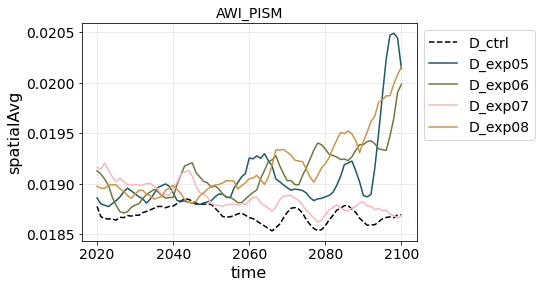

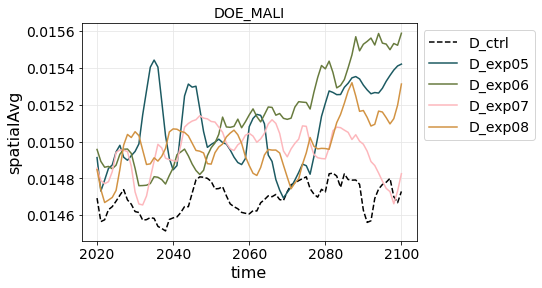

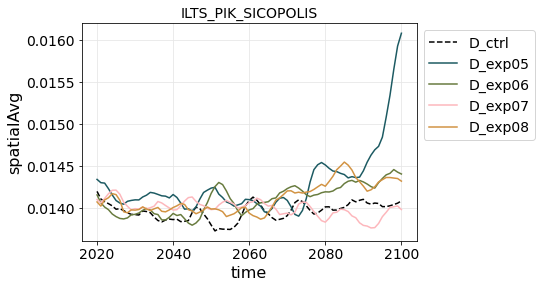

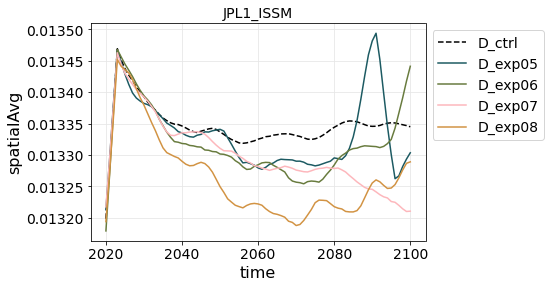

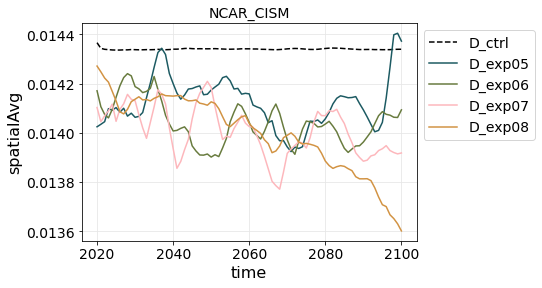

In [130]:
## Plot per model
# fig,axs=plt.subplots(5,1,figsize=(7,20)) # (6,20)

exp_var_list = list(dmg_ds_1d_all.data_vars)
for model_idx, ismip_model in enumerate(model_options):
    # select model, all experiments (convert to DA)
    ''' Spatial avg'''
    da_plot = dmg_ds_1d_all.isel(ismip_model=model_idx).to_array()
    # da_plot = dmg_ds_1d_all_avg.isel(ismip_model=model_idx).to_array()

    # ''' Spatial sum'''
    # da_plot = dmg_ds_1d_all_sum.isel(ismip_model=model_idx).to_array()

    
    # drop first t where values dmg= 0
    da_plot=da_plot.isel(time=slice(1,86))

    # moving window average
    da_plot = da_plot.rolling(time=5).mean()

    
    fig,ax=plt.subplots(1,figsize=(6,4))    
    # ax = axs[model_idx]
    # ax.set_prop_cycle( cycler(color=my_palette2) )
    # ax.set_prop_cycle( cycler(color=cubeH_palette) )
    ax.set_prop_cycle( cycler(color=exp_palette) )
    # class_palette = model_cmap_list[exp_idx]
    # class_palette = sns.color_palette("Set2",5 )
    # ax.set_prop_cycle( cycler(color=class_palette) )

    # D_ctrl
    h = da_plot.sel(variable='D_ctrl').plot.line(ax=ax, x='time' , linestyle='--')
    # D_exp
    h = da_plot.isel(variable=slice(1,5)).plot.line(ax=ax, x='time' )
    ax.set_title(ismip_model)
    # ax.legend(exp_var_list) # update names in legend
    ax.legend(exp_var_list,loc='upper left', bbox_to_anchor=(1, 1)) # update names in legend
    # ax.set_ylim([0.01, 0.02])
    ax.set_ylabel(sumLabel)
    ax.grid('major',color=[0.9, 0.9, 0.9],which='both')



    ### save fig
    figname = 'dmg_' + 'ismipModels_' +'absoluteDMG_'+ ismip_model + '_normSum.png' # v2 (new colors and single plots instead of subplots )
    print(figname)
    # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname), bbox_inches='tight')
# fig.tight_layout()


### save fig
# figname = 'dmg_' + 'ismipModels' + '_normSum.png' # v1
# fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname), bbox_inches='tight')